# Loading Data into FBL: Structure of Retrieved Data, SWC Files and Neuron Information

In this demo we show the basic data structures used to load data from the NeuroArch database into FlyBrainLab, demonstrating the structure and teaching you how to load your own data as part of a script.


**Important:** Before starting to run the code below, **(i)** create an FBL workspace for Hemibrain, **(ii)** change the kernel for this notebook to the kernel you just created.

In [4]:
%matplotlib inline
my_client = fbl.get_client()
data = my_client.executeNLPquery('show $_DM4$')

[FFBOLab Client NLP 2020-09-07 20:52:22] NLP successfully parsed query.
[FFBOLab Client NLP 2020-09-07 20:52:22] Received a message.
[FFBOLab Client NLP 2020-09-07 20:52:22] Received a command.
[FFBOLab Client NLP 2020-09-07 20:52:23] Received data.
[FFBOLab Client NLP 2020-09-07 20:52:23] Received a message.
[FFBOLab Client NLP 2020-09-07 20:52:23] Received data.
[]


We can now analyze the data retrieved with this query below. **data** is a list of dictionaries. Let us look at data[0]:

In [5]:
data[0]

{'data': {'info': {'success': 'Fetching results from NeuroArch'}},
 'messageType': 'Message',
 'widget': 'NLP'}

We can see that this is a message that informs the frontend that data is being retrieved. Note the keys and values of the message; this information can be used to create custom messages. 'widget' field determines the widget that's supposed to get this message; the default widget that these queries gets sent to is the 'NLP' widget that shows the 3D data.

In [6]:
data[1]

{'data': {'commands': {'reset': ''}},
 'messageType': 'Command',
 'widget': 'NLP'}

This message is a command that resets the whole workspace. The query of 'show' implies that old visualized data is to be removed from the workspace. If we were to query with ```my_client.executeNLPquery('add $_DM4$')``` we would not receive this message. Note that the messageType is 'Command' and the data field has a 'commands' field.

In [7]:
data[2].keys()

dict_keys(['data', 'messageType', 'widget'])

data[2] contains the actual neuron information, and will be printed out as a huge block of text if you choose to. Here, we sketch the basics instead:

In [8]:
data[2]['data']['data'].keys()

dict_keys(['#799:194'])

The value '#799:194' is an unique identifier associated with this neuron. When you are using custom data, '#799:194' can be replaced by anything you want. You can have multiple keys here corresponding to multiple neurons, and they will all be loaded when this message is sent to the server. Note that your identifier needs to start with a # sign.

In [9]:
data[2]['data']['data']['#799:194'].keys()

dict_keys(['name', 'uname', 'morph_type', 'x', 'y', 'z', 'r', 'parent', 'identifier', 'sample', 'class'])

Here, four of the keys are strings, while the rest are lists corresponding to each point in the neuron skeleton. The string-valued keys are shown below:

In [10]:
print(data[2]['data']['data']['#799:194']['name']) # the common name of the neuron
print(data[2]['data']['data']['#799:194']['uname']) # a unique name for the neuron
print(data[2]['data']['data']['#799:194']['class']) # class of this data, here morphology
print(data[2]['data']['data']['#799:194']['morph_type']) # type of the morphology, here .swc

DM4 adPN
mPN1_DM4(AVM01)_R_1
MorphologyData
swc


Our morphology data, as shown, uses the .swc format. The specification for this format is summarized below: http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html

You can see the contents of the columns corresponding to the specification in the following order: sample, identifier, x, y, z, r, parent.

In short, the primitive structure for loading a neuron looks like this:

In [11]:
neuron_data = {'data': {'data': {'#rid': {'name': 'my neuron',
                'uname': 'my neuron unique identifier',
                'morph_type': 'swc',
                'x': [],
                'y': [],
                'z': [],
                'r': [],
                'parent': [],
                'identifier': [],
                'sample': [],
                'class': 'MorphologyData'}},
              'queryID': '-'},
             'messageType': 'Data',
             'widget': 'NLP'}

where you can ignore the queryID field, used to check for uniqueness of a query for storing common queries in the server.

## Loading SWC
In this section, we will go over loading files. We will be loading the 425790257.swc swc file from the Hemibrain dataset, released as CC BY 4.0 https://www.janelia.org/project-team/flyem/hemibrain. 

In [12]:
import pandas as pd
neuron_pd = pd.read_csv('425790257.swc', 
                        names=['sample','identifier','x','y','z','r','parent'], 
                        comment='#', 
                        delim_whitespace=True)
neuron_pd

,sample,identifier,x,y,z,r,parent
0,1,0,15876.0,27816.0,8032.0,14.000,-1
1,2,0,15876.0,27816.0,8060.0,14.000,1
2,3,0,15904.0,27844.0,8088.0,14.000,2
3,4,0,15904.0,27844.0,8116.0,14.000,3
4,5,0,15904.0,27844.0,8144.0,14.000,4
...,...,...,...,...,...,...,...
181736,181737,0,21140.0,25212.0,27072.0,25.598,181736
181737,181738,0,21168.0,25184.0,27044.0,14.000,181737
181738,181739,0,20468.0,27340.0,29368.0,14.000,181665
181739,181740,0,20440.0,27368.0,29396.0,14.000,181739


Let us now construct our message:

In [13]:
scale_factor = 0.001 # A scale factor to put the neurons in the same scale as the meshes
neuron_data = {'data': {'data': {'#rid': {'name': 'our new neuron',
                'uname': 'our new neuron\'s unique name',
                'morph_type': 'swc',
                'x': list(scale_factor * neuron_pd['x']),
                'y': list(scale_factor * neuron_pd['y']),
                'z': list(scale_factor * neuron_pd['z']),
                'r': list(scale_factor * neuron_pd['r']),
                'parent': list(neuron_pd['parent']),
                'identifier': list(neuron_pd['identifier']),
                'sample': list(neuron_pd['sample']),
                'class': 'MorphologyData'}},
              'queryID': '0-0'},
             'messageType': 'Data',
             'widget': 'NLP'}

and send it to the frontend:

In [14]:
my_client.tryComms(neuron_data)

We just loaded the giant APL neuron! Your screen should look like the following:

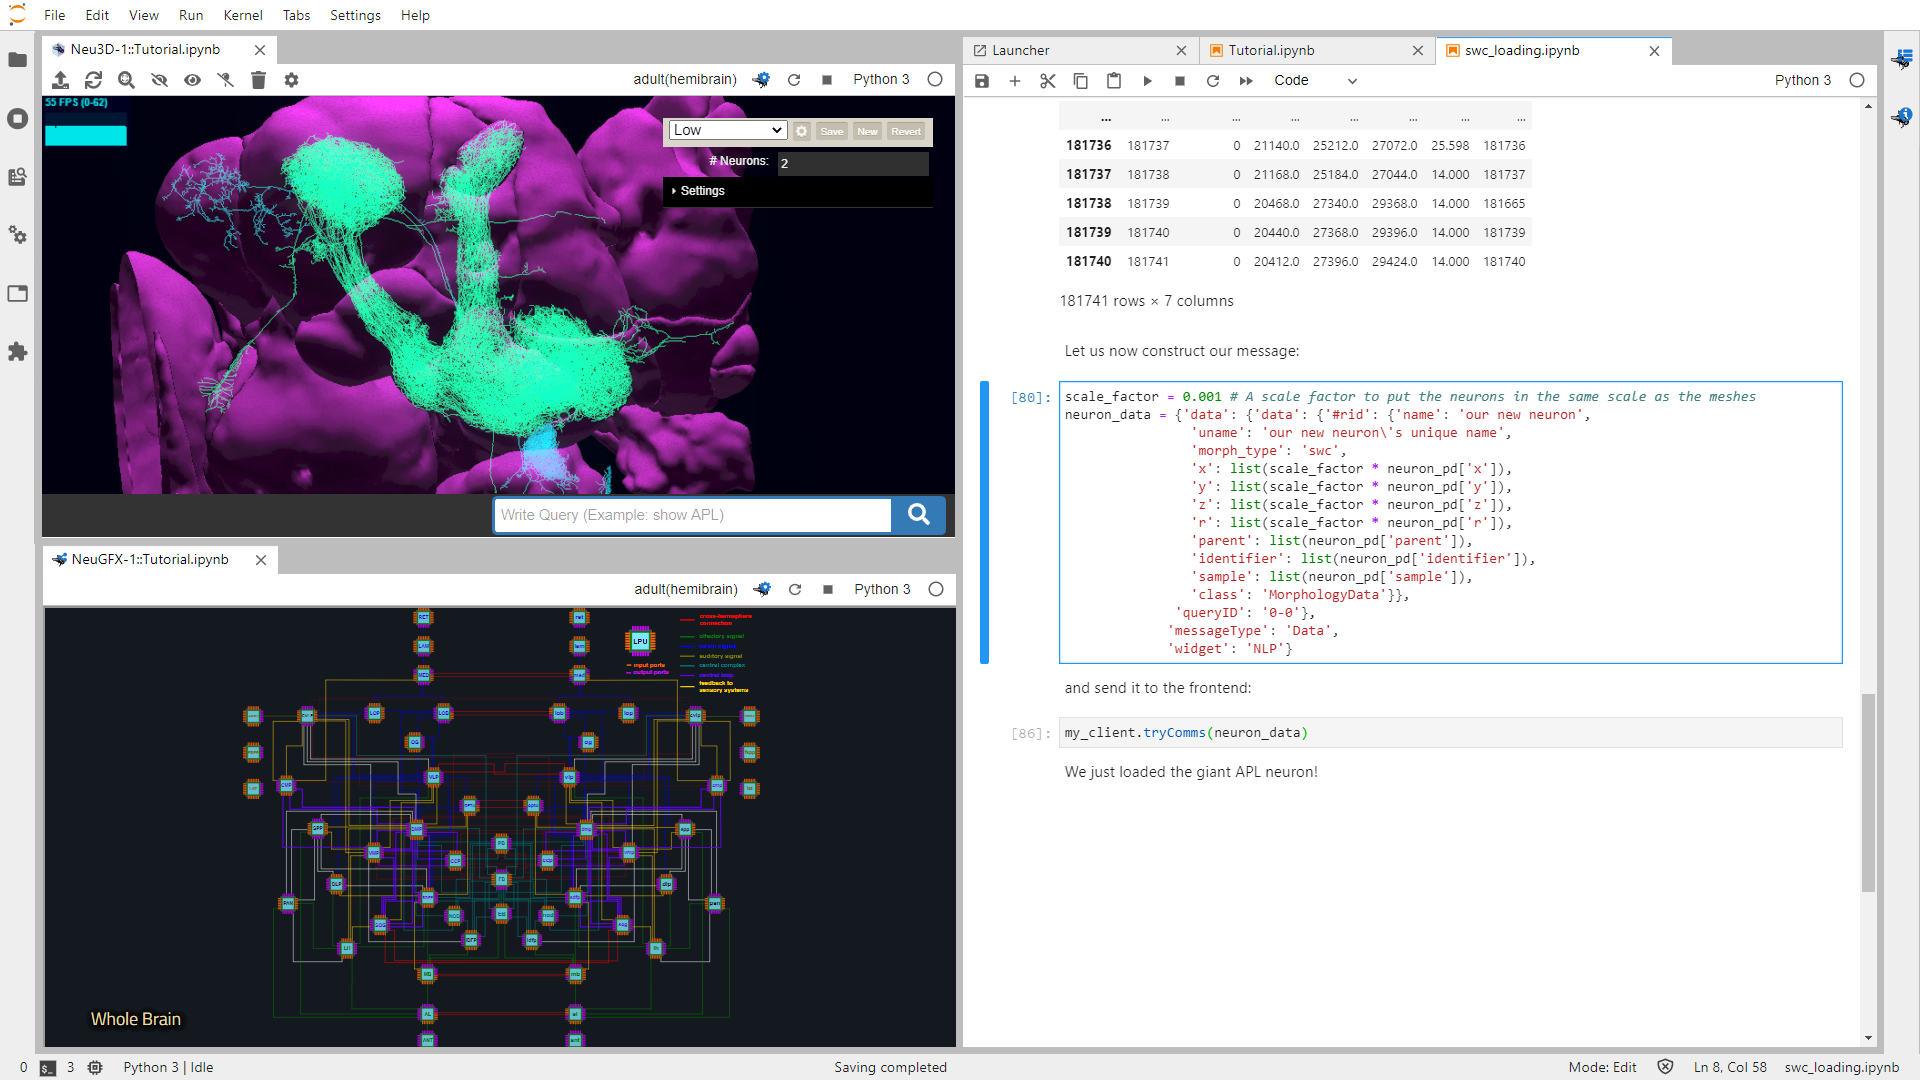

In [15]:
import requests
from IPython.display import Image 
url = "https://github.com/FlyBrainLab/Tutorials/raw/master/tutorials/swc_loading_tutorial/images/swc_loading_screenshot.png"
Image(requests.get(url).content)